# Search Ranking Stack - Interactive Walkthrough

This notebook walks through the multi-stage search ranking pipeline:

1. **Stage 1a**: BM25 Sparse Retrieval
2. **Stage 1b**: Dense Bi-Encoder Retrieval
3. **Stage 1c**: Hybrid RRF Fusion
4. **Stage 2**: Cross-Encoder Reranking
5. **Stage 3**: LLM Listwise Reranking (optional)

Each stage shows code, explains the approach, and evaluates performance on the SciFact dataset.

## Setup

First, let's import the necessary modules and load the data.

In [1]:
# Install dependencies if needed
# !uv sync --extra notebook

In [2]:
from search_ranking_stack.data_loader import load_scifact
from search_ranking_stack.evaluate import evaluate, format_metrics
from search_ranking_stack.stages import (
    run_bm25,
    run_dense,
    run_hybrid_rrf,
    run_cross_encoder,
    run_llm_rerank,
    llm_available,
)

## Load SciFact Dataset

SciFact is a biomedical claims dataset with:
- **5,183 documents**: Scientific paper abstracts
- **300 test queries**: Scientific claims to verify
- **Binary relevance labels**: Each claim has supporting/refuting evidence

In [3]:
data = load_scifact()

print(f"Corpus: {len(data.corpus):,} documents")
print(f"Queries: {len(data.queries):,} test queries")
print(f"Qrels: {len(data.qrels):,} query-document judgments")

Loading SciFact dataset...

Loading corpus...

Generating corpus split:   0%|          | 0/5183 [00:00<?, ? examples/s]

  Processing documents: 100%|██████████████████████| 5183/5183 [00:00<00:00, 127565.52it/s]


✓ Loaded 5,183 documents

Loading queries...

Generating queries split:   0%|          | 0/1109 [00:00<?, ? examples/s]

✓ Loaded 1,109 queries

Loading relevance judgments...

Generating train split:   0%|          | 0/919 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/339 [00:00<?, ? examples/s]

✓ Loaded relevance judgments for 300 queries

✓ Using 300 test queries with judgments

Corpus: 5,183 documents
Queries: 300 test queries
Qrels: 300 query-document judgments


In [4]:
# Let's look at a sample query and document
sample_qid = list(data.queries.keys())[0]
sample_query = data.queries[sample_qid]
print(f"Sample Query ({sample_qid}):")
print(f"  {sample_query}")

# Get a relevant document for this query
if sample_qid in data.qrels:
    rel_docs = data.qrels[sample_qid]
    sample_doc_id = list(rel_docs.keys())[0]
    print(f"\nRelevant Document ({sample_doc_id}):")
    print(f"  {data.corpus[sample_doc_id][:500]}...")

Sample Query (1):
  0-dimensional biomaterials show inductive properties.

Relevant Document (31715818):
  New opportunities: the use of nanotechnologies to manipulate and track stem cells. Nanotechnologies are emerging platforms that could be useful in measuring, understanding, and manipulating stem cells. Examples include magnetic nanoparticles and quantum dots for stem cell labeling and in vivo tracking; nanoparticles, carbon nanotubes, and polyplexes for the intracellular delivery of genes/oligonucleotides and protein/peptides; and engineered nanometer-scale scaffolds for stem cell differentiatio...


---

## Stage 1a: BM25 Sparse Retrieval

**BM25 (Best Matching 25)** is a classic lexical retrieval method:
- Matches query terms with document terms
- Uses TF-IDF weighting with length normalization
- Fast and interpretable, but misses semantic matches

```
BM25(q, d) = Σ IDF(t) × (tf × (k1+1)) / (tf + k1 × (1-b+b×|d|/avgdl))
```

In [5]:
bm25_results = run_bm25(data)
bm25_metrics = evaluate(data.qrels, bm25_results)
print("\n" + format_metrics(bm25_metrics))

Stage 1a: BM25 Retrieval

Indexing 5,183 documents...

done (0.2s)

Retrieving for 300 queries...

done (2.1s)


MRR@10: 0.5290 | Recall@100: 0.7929 | NDCG@10: 0.5597


---

## Stage 1b: Dense Bi-Encoder Retrieval

**Dense retrieval** uses neural embeddings:
- Encodes queries and documents into dense vectors
- Uses cosine similarity for matching
- Captures semantic meaning beyond keyword overlap

We use `all-MiniLM-L6-v2` (22M params, 384-dim embeddings).

In [6]:
dense_results = run_dense(data)
dense_metrics = evaluate(data.qrels, dense_results)
print("\n" + format_metrics(dense_metrics))

Stage 1b: Dense Bi-Encoder Retrieval (sentence-transformers/all-MiniLM-L6-v2)

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Encoding 5,183 documents...

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

done (23.1s)

Cached embeddings to corpus_embeddings.npy

Encoding 300 queries...

done (0.2s)

Computing similarities...

done (0.00s)


MRR@10: 0.6110 | Recall@100: 0.9250 | NDCG@10: 0.6451


---

## Stage 1c: Hybrid RRF Fusion

**Reciprocal Rank Fusion (RRF)** combines multiple ranking lists:

```
RRF_score(d) = Σ 1/(k + rank(d, r))  for each ranking r
```

Where `k=60` (from Cormack et al. 2009). RRF is:
- **Rank-based**: Robust to different score scales
- **Simple**: No hyperparameter tuning needed
- **Effective**: Often outperforms individual methods

In [7]:
hybrid_results = run_hybrid_rrf(bm25_results, dense_results)
hybrid_metrics = evaluate(data.qrels, hybrid_results)
print("\n" + format_metrics(hybrid_metrics))

Stage 1c: Hybrid Search (RRF Fusion, k=60)

Fusing BM25 + Dense results for 300 queries...

done (0.01s)

Example — Query 1086:

Hybrid rescued 3 doc(s) into top-10 that weren't in either individual top-10


MRR@10: 0.6129 | Recall@100: 0.9287 | NDCG@10: 0.6391


---

## Stage 2: Cross-Encoder Reranking

**Cross-encoders** score query-document pairs jointly:
- Concatenates query and document: `[CLS] query [SEP] document [SEP]`
- Full attention between query and document tokens
- More accurate than bi-encoders, but slower

We rerank the top-50 candidates from hybrid retrieval.

In [8]:
ce_results = run_cross_encoder(data, hybrid_results)
ce_metrics = evaluate(data.qrels, ce_results)
print("\n" + format_metrics(ce_metrics))

Stage 2: Cross-Encoder Reranking (cross-encoder/ms-marco-MiniLM-L-12-v2)

Loading cross-encoder model...

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: cross-encoder/ms-marco-MiniLM-L-12-v2
Key                          | Status     |  | 
-----------------------------+------------+--+-
bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Reranking top-50 candidates per query...

  Reranking: 100%|███████████████████████████████████████| 300/300 [06:25<00:00,  1.29s/it]


300/300 queries reranked (avg 1286ms/query)


MRR@10: 0.6144 | Recall@100: 0.9287 | NDCG@10: 0.6235


---

## Stage 3: LLM Listwise Reranking (Optional)

**LLM rerankers** use large language models for final reranking:
- Presents top-10 documents to the LLM
- Asks for a listwise ranking judgment
- Inspired by RankGPT approach

Requires either `[llm]` extras (local Qwen) or `[api]` extras (Claude).

In [9]:
if llm_available():
    llm_results = run_llm_rerank(data, ce_results)
    llm_metrics = evaluate(data.qrels, llm_results)
    print("\n" + format_metrics(llm_metrics))
else:
    print("LLM reranking not available.")
    print("Install with: uv sync --extra llm  (or --extra api)")

LLM reranking not available.
Install with: uv sync --extra llm  (or --extra api)


---

## Results Comparison

Let's visualize the results across all stages.

In [10]:
from search_ranking_stack.visualize import plot_comparison, print_table

all_metrics = {
    "BM25": bm25_metrics,
    "Dense Bi-Encoder": dense_metrics,
    "Hybrid (RRF)": hybrid_metrics,
    "+ Cross-Encoder": ce_metrics,
}

# Add LLM results if available
if llm_available() and "llm_metrics" in dir():
    all_metrics["+ LLM Reranker"] = llm_metrics

print_table(all_metrics)

            Search Ranking Stack Results            
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┓
┃ Stage            ┃ NDCG@10 ┃ MRR@10 ┃ Recall@100 ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━┩
│ BM25             │  0.5597 │ 0.5290 │     0.7929 │
│ Dense Bi-Encoder │  0.6451 │ 0.6110 │     0.9250 │
│ Hybrid (RRF)     │  0.6391 │ 0.6129 │     0.9287 │
│ + Cross-Encoder  │  0.6235 │ 0.6144 │     0.9287 │
└──────────────────┴─────────┴────────┴────────────┘

✓ Chart saved to: /Users/slava/Projects/search-ranking-stack/results/metrics_comparison.png

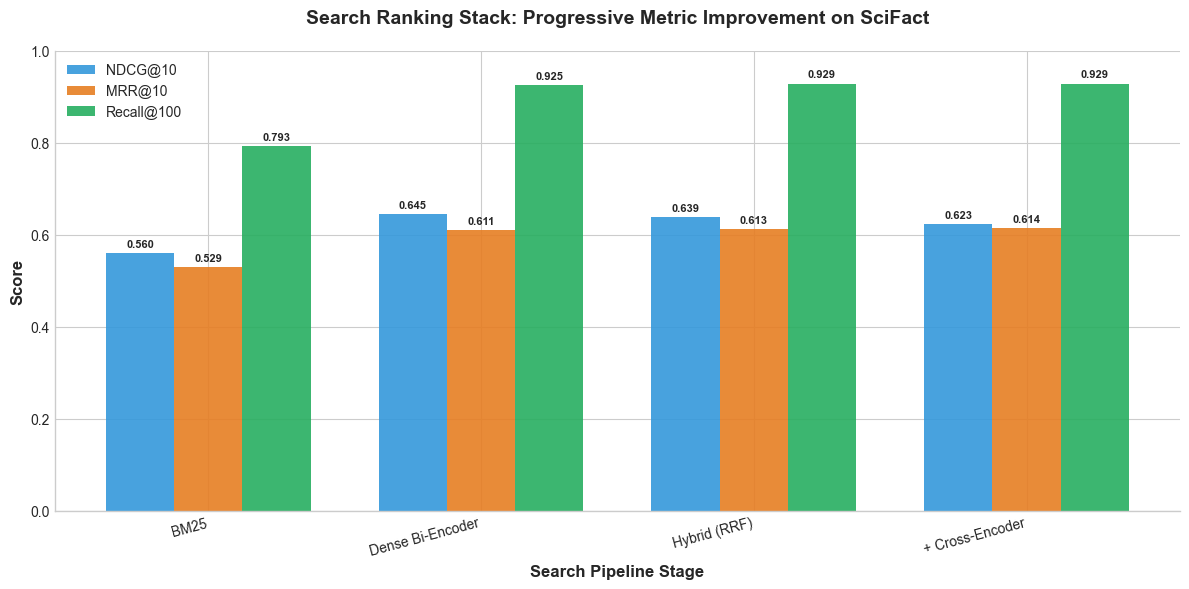

PosixPath('/Users/slava/Projects/search-ranking-stack/results/metrics_comparison.png')

In [11]:
# Generate and display chart
import matplotlib.pyplot as plt

plot_comparison(all_metrics, show=True)

---

## Key Insights

1. **Dense bi-encoder significantly outperforms BM25** on SciFact
   - Scientific language benefits from semantic matching
   - Recall@100 jumps from ~79% to ~93%

2. **Hybrid RRF combines strengths** of both methods
   - Improved recall over individual methods
   - Robust to failures in either retriever

3. **Reranking can't fix retrieval misses**
   - Recall@100 stays constant after Stage 1c
   - Rerankers only reorder existing candidates

4. **Results are dataset-dependent**
   - Cross-encoder impact varies by domain
   - Always evaluate on your target data!

---

## Try Your Own Query

Let's test the pipeline with a custom query.

In [12]:
from rank_bm25 import BM25Okapi
from sentence_transformers import SentenceTransformer, CrossEncoder
import numpy as np

# Your query here
my_query = "Does caffeine improve cognitive performance?"

# Quick search using dense retrieval
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
query_emb = model.encode([my_query], normalize_embeddings=True)

# Load cached corpus embeddings
from search_ranking_stack.config import CORPUS_EMBEDDINGS_PATH

corpus_embs = np.load(CORPUS_EMBEDDINGS_PATH)

# Find top-5 similar documents
doc_ids = list(data.corpus.keys())
scores = np.dot(query_emb, corpus_embs.T)[0]
top_indices = np.argsort(scores)[::-1][:5]

print(f"Query: {my_query}\n")
print("Top 5 Results:")
for i, idx in enumerate(top_indices, 1):
    doc_id = doc_ids[idx]
    doc_text = data.corpus[doc_id][:200]
    print(f"\n{i}. [{doc_id}] (score: {scores[idx]:.4f})")
    print(f"   {doc_text}...")

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Query: Does caffeine improve cognitive performance?

Top 5 Results:

1. [50670403] (score: 0.5093)
   Are expert athletes 'expert' in the cognitive laboratory? A meta-analytic review of cognition and sport expertise SUMMARY Recent literature has demonstrated the usefulness of fitness and computer-base...

2. [7965928] (score: 0.4569)
   Relationship of collegiate football experience and concussion with hippocampal volume and cognitive outcomes. IMPORTANCE Concussion and subconcussive impacts have been associated with short-term disru...

3. [2424794] (score: 0.4273)
   A neuroimaging investigation of the association between aerobic fitness, hippocampal volume, and memory performance in preadolescent children. Because children are becoming overweight, unhealthy, and ...

4. [24865781] (score: 0.4098)
   A comparison of pharmacological (amitriptyline HCL) and nonpharmacological (cognitive-behavioral) therapies for chronic tension headaches. Forty-one recurrent tension headache sufferers 